## AR Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

In this case an AR(1) model is used.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

np.random.seed(1234)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
n_samples = 250000
alpha_value = 0.2
sigma_2_value = 1.**2

shared_alpha = theano.shared(alpha_value, name="alpha")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")

class AR:
    def __init__(self,alpha,sigma_2):
        self.alpha = alpha
        self.sigma_2 = sigma_2
    
    def sample(self, alpha=0.2, sigma_2=1.,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        for i in range(1,n_timesteps):
            time_serie[i] = alpha*time_serie[i-1] + noise[i]

        return time_serie.reshape(time_serie.shape[0],1), time_serie.reshape(time_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(alpha=self.alpha.eval(),sigma_2=self.sigma_2.eval(),
                     n_timesteps=n_samples,rng=rng)[0]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [3]:
p0 = AR(alpha=shared_alpha,sigma_2=shared_sigma_2)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = AR(alpha = theano.shared(0.6, name="alpha_1"),
        sigma_2 = theano.shared(sigma_2_value,name="sigma_2_1")
            )
rng = np.random.RandomState(1234)

X_true = p0.rvs(15000,random_state=rng)
print X_true

[[ 0.47143516]
 [-1.09668866]
 [ 1.21336924]
 ..., 
 [-0.13610761]
 [-0.05613482]
 [ 1.62583342]]


-4.30320230331 4.60571741359
-5.22231174696 5.17028983347


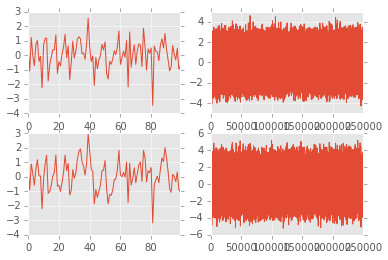

In [4]:
serie1 = p0.rvs(n_samples).ravel()
serie2 = p1.rvs(n_samples).ravel()
plt.figure(1)
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [5]:
from carl.learning import make_parameterized_classification

X, y = make_parameterized_classification(
    p0, p1,
    500000, 
    [(shared_alpha, np.linspace(0.01,1., num=10))],
    random_state=1234)

In [6]:
print X
print y

[[ 0.47143516  0.01      ]
 [-1.18626134  0.01      ]
 [ 1.42084435  0.01      ]
 ..., 
 [ 0.66287158  1.        ]
 [ 1.2126133   1.        ]
 [ 1.12447083  1.        ]]
[ 0.  0.  0. ...,  1.  1.  1.]


In [51]:
max_len = 5
X0_serie = []
y0_serie = []
X1_serie = []
y1_serie = []

X0 = X[y == 0]
X1 = X[y == 1]
for i in xrange(X0.shape[0]-max_len+1):
    # ensure that is from same time serie
    if X0[i][-1] == X0[i+max_len-1][-1]:
        X0_serie.append(X0[i:i+max_len])
    if X1[i][-1] == X1[i+max_len-1][-1]:
        X1_serie.append(X1[i:i+max_len])
X0_serie = np.array(X0_serie)
X1_serie = np.array(X1_serie)

X_serie = np.vstack((
     X0_serie,
     X1_serie))
y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
y_serie[X0_serie.shape[0]:] = 1


In [52]:
print(X_serie)

[[[ 0.47143516  0.01      ]
  [-1.18626134  0.01      ]
  [ 1.42084435  0.01      ]
  [-0.29844345  0.01      ]
  [-0.72357317  0.01      ]]

 [[-1.18626134  0.01      ]
  [ 1.42084435  0.01      ]
  [-0.29844345  0.01      ]
  [-0.72357317  0.01      ]
  [ 0.87992721  0.01      ]]

 [[ 1.42084435  0.01      ]
  [-0.29844345  0.01      ]
  [-0.72357317  0.01      ]
  [ 0.87992721  0.01      ]
  [ 0.86838769  0.01      ]]

 ..., 
 [[-0.13446493  1.        ]
  [-1.32209174  1.        ]
  [-0.08647195  1.        ]
  [-0.38336679  1.        ]
  [ 0.66287158  1.        ]]

 [[-1.32209174  1.        ]
  [-0.08647195  1.        ]
  [-0.38336679  1.        ]
  [ 0.66287158  1.        ]
  [ 1.2126133   1.        ]]

 [[-0.08647195  1.        ]
  [-0.38336679  1.        ]
  [ 0.66287158  1.        ]
  [ 1.2126133   1.        ]
  [ 1.12447083  1.        ]]]


In [53]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM
from carl.learning import as_classifier
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def scheduler(epoch):
    if (epoch + 1) % 25 == 0:
        lr_val = model.optimizer.lr.get_value()
        model.optimizer.lr.set_value(lr_val*0.5)
    return float(model.optimizer.lr.get_value())

sgd = SGD(lr=0.01, clipnorm = 40.)

model = Sequential()
model.add(GRU(10,input_shape=(max_len,2)))
model.add(Dense(5,activation='tanh'))
model.add(Dense(1,activation='tanh'))

#model.compile(loss='mean_squared_error', optimizer='rmsprop')
from keras_wrapper import KerasClassifier
lr_schedule = LearningRateScheduler(scheduler)

clf = KerasClassifier(model=model, loss='mean_squared_error', optimizer=sgd, nb_epoch=40, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X_serie, y=y_serie)
#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/40
18s - loss: 0.2355
Epoch 2/40
18s - loss: 0.2276
Epoch 3/40
14s - loss: 0.2250
Epoch 4/40
13s - loss: 0.2233
Epoch 5/40
15s - loss: 0.2220
Epoch 6/40
17s - loss: 0.2208
Epoch 7/40
14s - loss: 0.2198
Epoch 8/40
15s - loss: 0.2186
Epoch 9/40
14s - loss: 0.2174
Epoch 10/40
13s - loss: 0.2158
Epoch 11/40
13s - loss: 0.2143
Epoch 12/40
14s - loss: 0.2131
Epoch 13/40
14s - loss: 0.2124
Epoch 14/40
14s - loss: 0.2119
Epoch 15/40
13s - loss: 0.2114
Epoch 16/40
13s - loss: 0.2109
Epoch 17/40
14s - loss: 0.2104
Epoch 18/40
14s - loss: 0.2099
Epoch 19/40
14s - loss: 0.2094
Epoch 20/40
13s - loss: 0.2088
Epoch 21/40
13s - loss: 0.2084
Epoch 22/40
13s - loss: 0.2080
Epoch 23/40
13s - loss: 0.2077
Epoch 24/40
13s - loss: 0.2074
Epoch 25/40
13s - loss: 0.2072
Epoch 26/40
14s - loss: 0.2070
Epoch 27/40
15s - loss: 0.2069
Epoch 28/40
15s - loss: 0.2067
Epoch 29/40
16s - loss: 0.2066
Epoch 30/40
14s - loss: 0.2064
Epoch 31/40
13s - loss: 0.2063
Epoch 32/40
13s - loss: 0.2061
Epoch 33/40
14s -

In [54]:
print clf.predict_proba(X_serie)

[[ 0.09887205]
 [ 0.14001386]
 [ 0.31968889]
 ..., 
 [ 0.84231573]
 [ 0.82120478]
 [ 0.83303928]]


In [55]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=50, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras_wrapper.KerasClassifier object at 0x11d0bc750>,
            bins=50, cv='prefit', eps=0.1, method='histogram'),
        random_state=0)

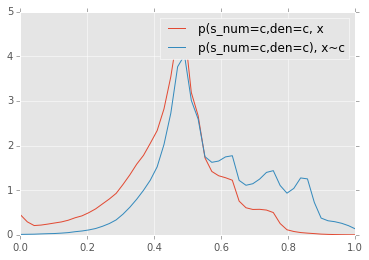

In [56]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0]
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [57]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 5000
def objective(theta, random_state=0):    
    print(theta)
    shared_alpha.set_value(theta[0])
    serie1 = p0.rvs(n_samples)
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+1))
    X0[:,:-1] = serie1
    X0[:,-1] = theta
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    #serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
    serie2 = p1.rvs(n_samples,random_state=random_state)
    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+1))
    X1[:,:-1] = serie2
    X1[:,-1] = 0.6

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+1))
    X_true_[:,:-1] = X_true
    X_true_[:,-1] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    
    r = ratio.predict(X_true_serie, log=True)
    print r[np.isfinite(r)].shape
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
            
    return value

In [58]:
from GPyOpt.methods import BayesianOptimization
bounds = [(0.01,1.0)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.66316343]
(14960,)
[ 0.50715028]
(14764,)
[ 0.29228909]
(12104,)
[ 0.29117285]
(12080,)
[ 0.84326126]
(1243,)
[ 0.9765227]
(34,)
[ 0.81238325]
(2362,)
[ 0.01]
(10353,)
[ 0.84266329]
(1253,)
[ 0.83951166]
(1293,)
[ 0.83880146]
(1300,)
[ 0.83217551]
(1372,)
[ 0.80070406]
(3662,)
[ 0.79347002]
(3846,)
[ 0.80171347]
(3638,)
[ 0.86451586]
(691,)
[ 0.904976]
(265,)
[ 0.92637899]
(137,)
[ 0.14674861]
(10788,)
[ 0.80175976]
(3636,)
[ 0.80178069]
(3634,)
[ 0.39777641]
(13653,)
[ 0.80177107]
(3635,)
[ 0.80177898]
(3634,)
[ 0.84739464]
(1189,)
[ 0.88758832]
(350,)
[ 0.8019708]
(3630,)
[ 0.58590819]
(14904,)
[ 0.80194522]
(3630,)
[ 0.79621269]
(3782,)
[ 0.80179901]
(3634,)
[ 0.82814428]
(1415,)
[ 0.80187055]
(3632,)
[ 0.80856583]
(2423,)
[ 0.90941639]
(241,)
[ 0.86926428]
(652,)
[ 0.87391054]
(620,)
[ 0.81664348]
(2281,)
[ 0.89936336]
(289,)
[ 0.91514783]
(219,)
[ 0.87843311]
(397,)
[ 0.85888653]
(749,)
[ 0.78679782]
(4007,)
[ 0.78204872]
(5834,)
[ 0.77968406]
(5930,)
[ 0.77555893]
(6083,)
[ 0

1

In [59]:
approx_MLE = solver.x_opt
print solver.x_opt
print("Approx. MLE =", approx_MLE)

[ 0.76155569]
('Approx. MLE =', array([ 0.76155569]))


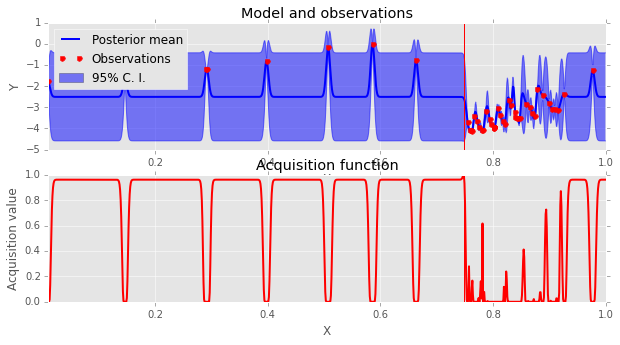

In [60]:
solver.plot_acquisition()

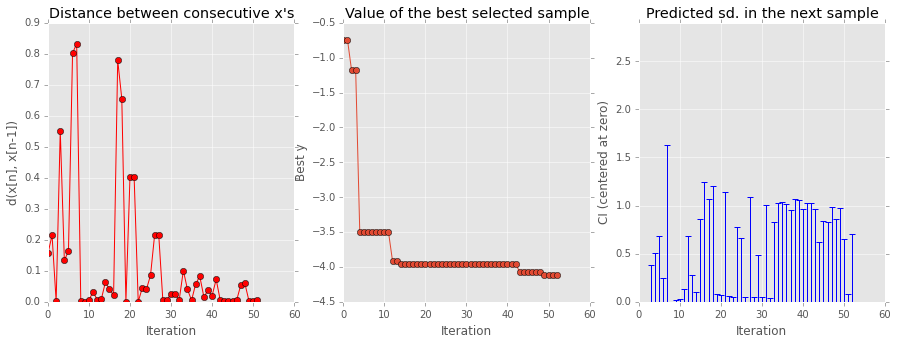

In [61]:
solver.plot_convergence()

In [62]:
from scipy.optimize import minimize
shared_alpha.set_value(alpha_value)
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0.4])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

('GP MLE =', array([ 28.49570116]))


In [63]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
#bounds = [(38., 58.0)]
As = np.linspace(bounds[0][0],bounds[0][1], 50)

n_points = 30

clf = clf
n_samples = n_samples
#As = np.linspace(*bounds[0], 100)
nll_gp, var_gp = solver.model.predict(As.reshape(-1, 1))
nll_gp = 2. * (nll_gp - nll_gp.min()) * len(X_true)
gp_ratios = nll_gp
# STD
std_gp = np.sqrt(4*var_gp*len(X_true)*len(X_true))
std_gp[np.isnan(std_gp)] = 0.
gp_std = std_gp
# 95% CI
q1_gp, q2_gp = solver.model.predict_quantiles(As.reshape(-1, 1))
q1_gp = 2. * (q1_gp - r.fun) * len(X_true)
q2_gp = 2. * (q2_gp - r.fun) * len(X_true)
gp_q1 = q1_gp
gp_q2 = q2_gp

[[ 68777.24503116]
 [ 46695.87616431]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46697.17545043]
 [ 56502.61679652]
 [ 46695.87484639]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.89523663]
 [ 84976.04845918]
 [ 46695.87538587]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.87484882]
 [ 74259.65142626]
 [ 46696.88500335]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46851.27728179]
 [ 52055.55482768]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 47781.56742636]
 [ 47958.85314564]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 55503.23500697]
 [ 46724.98037619]
 [ 46695.87484612]
 [ 46695.87484612]
 [ 46695.81812708]
 [     0.        ]
 [  3117.35131733]
 [  8048.47037589]
 [  8981.00579561]
 [ 31076.52709578]
 [ 37145.52845338]
 [ 59064.68907995]
 [ 38231.99248872]
 [ 38353.87028013]
 [ 46700.74421626]
 [ 46696.19308106]
 [ 71023.41386024]
 [ 46695.87485278]]


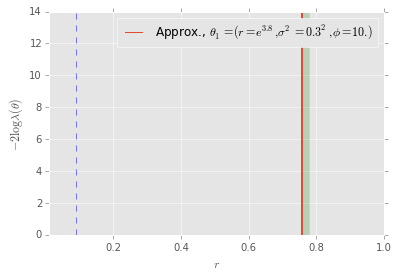

In [65]:
#bounds = [(42.,46.)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
print gp_ratios

ax.plot(As, gp_ratios, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
ax.fill_between(As,(gp_ratios - gp_std).ravel(),(gp_ratios + gp_std).ravel(),
                     color='g',alpha=0.2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()


ax.legend()
ax.set_ylim(0, 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=0.3**2,ymin=0.,ymax=4.,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model